# Feature Loss

This is the notebook for the feature loss training technique.

## Imports

In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

## Data

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
  %cp "/content/drive/My Drive/autoencoder-training/model_layers.py" .
  %cp "/content/drive/My Drive/autoencoder-training/baseline_model.py" .
  import baseline_model
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"
  from resnet_autoencoder_training import baseline_model

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
batchsize = 128

#tfms = get_transforms(do_flip = True)
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0, 
                      p_lighting=0.75)
src = (ImageImageList.from_folder(image_path).use_partial_data(0.1).split_by_folder().label_from_func(lambda x: x))
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=batchsize)
        .normalize(imagenet_stats, do_y = False))

## Model

In [0]:
autoencoder = baseline_model.autoencoder()

In [7]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

from torchvision.models import vgg16_bn
vgg_m = vgg16_bn(True).features.cuda().eval()

requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]

from fastai.callbacks import *
from fastai.utils.mem import *

base_loss = F.mse_loss

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [0]:
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [10]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.549746,0.529848,0.142619,0.301688,00:15
1,0.476219,0.460359,0.098031,0.246867,00:15
2,0.432242,0.417909,0.067444,0.204082,00:15
3,0.400028,0.395583,0.051213,0.176331,00:15
4,0.374044,0.374967,0.040584,0.153790,00:15
5,0.352332,0.361496,0.035563,0.143626,00:15
6,0.334378,0.348797,0.031491,0.136088,00:15
7,0.319095,0.332366,0.026612,0.127188,00:15
8,0.306653,0.323508,0.024664,0.119753,00:15
9,0.296254,0.319921,0.024458,0.119274,00:15


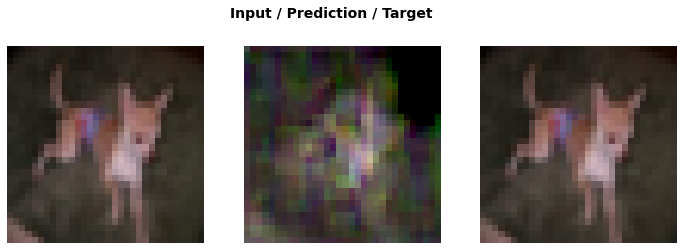

In [11]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,10,2])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [14]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.217403,0.256979,0.019996,0.106526,00:15
1,0.221708,0.267085,0.020981,0.109110,00:15
2,0.230110,0.276829,0.023034,0.114753,00:15
3,0.232693,0.269990,0.021804,0.111497,00:15
4,0.230384,0.264965,0.021461,0.111076,00:15
5,0.225713,0.259197,0.020764,0.107779,00:15
6,0.219695,0.252131,0.019181,0.103685,00:15
7,0.213133,0.246722,0.018583,0.101936,00:15
8,0.207130,0.244155,0.018273,0.101210,00:15
9,0.203681,0.242753,0.018294,0.101076,00:15


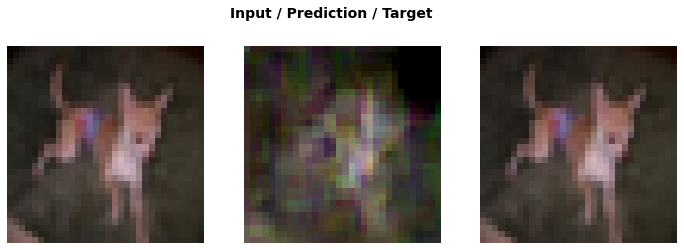

In [15]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,5,2])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [17]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.178022,0.216873,0.017872,0.099823,00:15
1,0.181092,0.223426,0.018678,0.102356,00:15
2,0.186870,0.230576,0.019674,0.104960,00:15
3,0.190334,0.233910,0.020767,0.108631,00:15
4,0.188969,0.221739,0.018087,0.100356,00:15
5,0.185561,0.216214,0.017458,0.098413,00:15
6,0.180943,0.211853,0.016816,0.096131,00:15
7,0.175609,0.207766,0.016540,0.094980,00:15
8,0.171494,0.205801,0.016391,0.094611,00:15
9,0.167914,0.205148,0.016213,0.093825,00:15


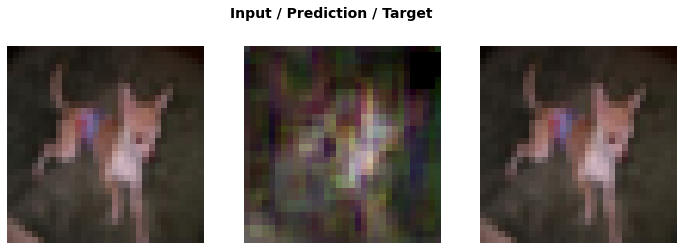

In [18]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [2,5,2])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [20]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.128392,0.163086,0.016336,0.094136,00:15
1,0.130624,0.169875,0.016763,0.095702,00:15
2,0.137034,0.177281,0.018892,0.102195,00:15
3,0.140693,0.172242,0.017758,0.098660,00:15
4,0.140693,0.170728,0.017327,0.097361,00:15
5,0.138841,0.167754,0.017308,0.097057,00:14
6,0.135115,0.165504,0.015926,0.092571,00:14
7,0.130796,0.161091,0.015808,0.092193,00:15
8,0.127687,0.160011,0.015617,0.091267,00:15
9,0.125204,0.159452,0.015559,0.091086,00:15


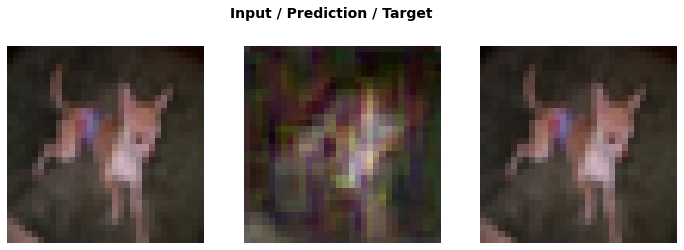

In [21]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [2,5,10])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [23]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.384908,0.531346,0.016293,0.093301,00:15
1,0.397660,0.548937,0.019188,0.102263,00:15
2,0.449899,0.605879,0.025134,0.118879,00:15
3,0.461932,0.568465,0.021914,0.111369,00:15
4,0.456541,0.564967,0.021171,0.108479,00:15
5,0.447578,0.538689,0.019714,0.104201,00:15
6,0.435424,0.541186,0.020108,0.105673,00:15
7,0.421488,0.530931,0.019262,0.102906,00:15
8,0.408358,0.525217,0.018819,0.101245,00:15
9,0.399266,0.524687,0.018796,0.101183,00:15


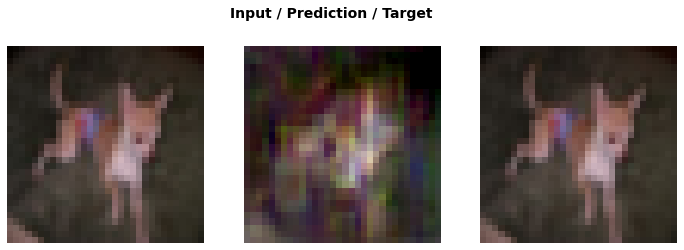

In [24]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [10,5,2])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [27]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.230590,0.276589,0.017112,0.096351,00:14
1,0.226671,0.274496,0.016699,0.095155,00:15
2,0.225651,0.275295,0.016430,0.094497,00:15
3,0.223297,0.271480,0.016458,0.094189,00:15
4,0.221024,0.266362,0.016086,0.093124,00:15
5,0.216332,0.260356,0.015442,0.091202,00:15
6,0.210161,0.253095,0.014795,0.088468,00:15
7,0.204824,0.249833,0.014677,0.087960,00:15
8,0.200092,0.247744,0.014488,0.087296,00:15
9,0.196888,0.247839,0.014447,0.087158,00:15


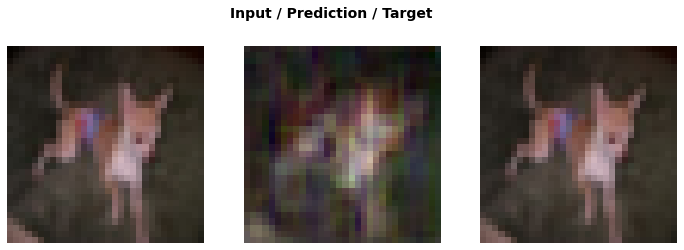

In [28]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,3,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [30]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.104740,0.133187,0.014073,0.085858,00:15
1,0.105497,0.135200,0.013995,0.085819,00:15
2,0.107786,0.138510,0.014682,0.088670,00:15
3,0.109043,0.136986,0.015065,0.090479,00:15
4,0.108672,0.134185,0.013761,0.085257,00:15
5,0.106908,0.130947,0.013364,0.084015,00:15
6,0.104452,0.128435,0.012915,0.082344,00:15
7,0.101883,0.126156,0.012925,0.082038,00:15
8,0.099512,0.124996,0.012670,0.080988,00:15
9,0.097848,0.124793,0.012703,0.081094,00:15


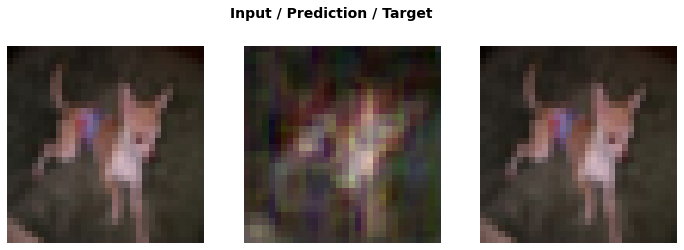

In [31]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [10,1,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [33]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.137059,0.172595,0.012593,0.080740,00:15
1,0.138181,0.174555,0.012618,0.081284,00:15
2,0.140481,0.177001,0.013309,0.083815,00:15
3,0.141031,0.175375,0.013019,0.082447,00:15
4,0.139822,0.171767,0.013308,0.083938,00:15
5,0.137535,0.168164,0.012341,0.080522,00:14
6,0.134029,0.164092,0.012116,0.079158,00:15
7,0.130608,0.161793,0.011850,0.078227,00:14
8,0.127619,0.160519,0.011823,0.077896,00:14
9,0.125934,0.160044,0.011821,0.077876,00:15


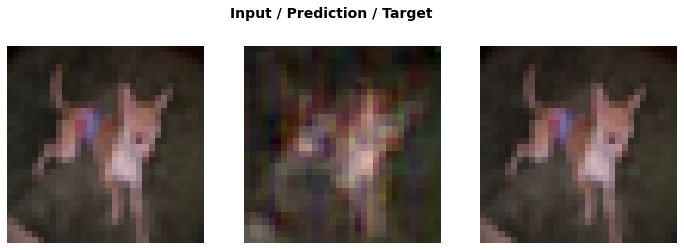

In [34]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [10,1,10])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [36]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.378351,0.532049,0.012701,0.081023,00:14
1,0.393224,0.559089,0.014332,0.087539,00:14
2,0.418830,0.594681,0.015457,0.090989,00:14
3,0.437139,0.581362,0.015614,0.091683,00:15
4,0.440929,0.586659,0.015973,0.093045,00:15
5,0.435370,0.574127,0.015497,0.091164,00:14
6,0.424624,0.553455,0.015556,0.090993,00:14
7,0.409236,0.543979,0.014625,0.087900,00:15
8,0.397036,0.536680,0.014578,0.087606,00:15
9,0.385510,0.535364,0.014423,0.087078,00:15


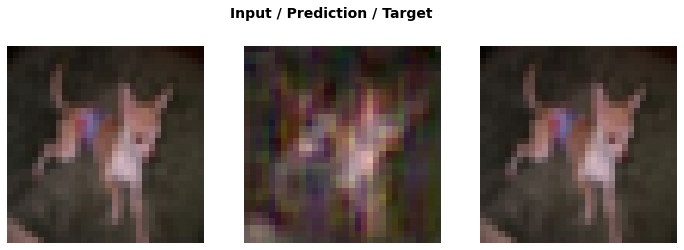

In [37]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [20,5,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [39]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.236752,0.293232,0.013213,0.083256,00:14
1,0.231880,0.288650,0.012886,0.082411,00:15
2,0.230242,0.290017,0.012931,0.082424,00:14
3,0.229721,0.283457,0.012516,0.080962,00:14
4,0.225649,0.275518,0.012127,0.079378,00:15
5,0.220347,0.270753,0.012017,0.078881,00:14
6,0.214567,0.265693,0.011718,0.077677,00:15
7,0.209014,0.261356,0.011861,0.078058,00:14
8,0.204981,0.258802,0.011629,0.077140,00:14
9,0.201975,0.258133,0.011571,0.076802,00:14


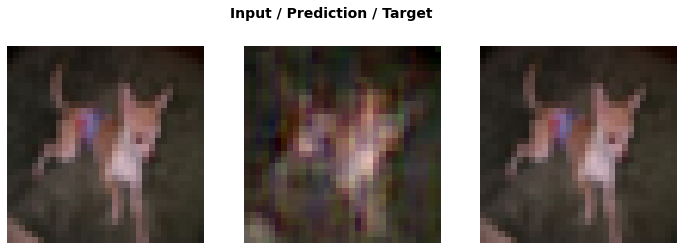

In [40]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [50,5,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [42]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.425832,0.543412,0.011569,0.076997,00:14
1,0.433233,0.621982,0.021310,0.111736,00:14
2,0.444930,0.560274,0.012834,0.082457,00:14
3,0.440597,0.550726,0.012259,0.080113,00:14
4,0.435199,0.543176,0.012059,0.079242,00:14
5,0.431201,0.541229,0.013058,0.083889,00:15
6,0.419750,0.519964,0.011508,0.077105,00:14
7,0.409812,0.511316,0.011407,0.076647,00:15
8,0.402687,0.506934,0.011491,0.076880,00:14
9,0.397130,0.506059,0.011422,0.076545,00:14


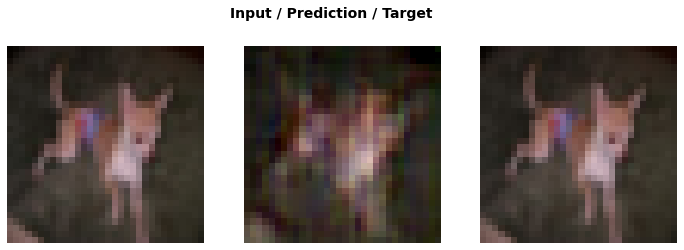

In [43]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [100,5,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [45]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.741893,0.954195,0.011612,0.077407,00:14
1,0.751315,0.975359,0.012237,0.079819,00:15
2,0.765245,0.990872,0.012314,0.080386,00:15
3,0.773692,0.982020,0.012248,0.080244,00:15
4,0.765717,0.956762,0.011649,0.078282,00:15
5,0.751800,0.937109,0.012589,0.081926,00:15
6,0.736116,0.918604,0.011469,0.077116,00:15
7,0.720024,0.906763,0.011243,0.075912,00:15
8,0.705057,0.894896,0.011325,0.076475,00:15
9,0.696702,0.893565,0.011302,0.076321,00:15


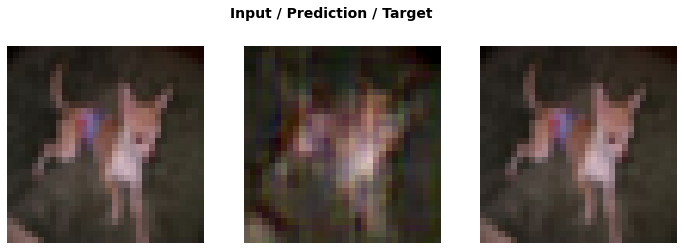

In [46]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [100,20,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [48]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.728416,0.951452,0.011501,0.077171,00:15
1,0.737523,0.978592,0.011811,0.078739,00:15
2,0.756973,0.992249,0.011443,0.077059,00:15
3,0.772201,1.063069,0.013456,0.085137,00:15
4,0.779157,0.976406,0.013115,0.084395,00:15
5,0.761212,0.948649,0.011599,0.077804,00:15
6,0.740475,0.935272,0.011622,0.077509,00:15
7,0.723538,0.918281,0.010948,0.074843,00:15
8,0.708751,0.908987,0.011285,0.076439,00:15
9,0.698580,0.905721,0.011350,0.076704,00:15


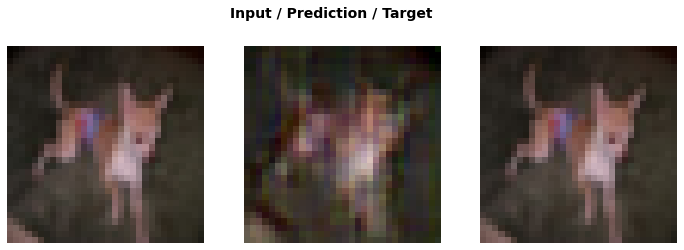

In [49]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [100,100,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [51]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.886389,1.185578,0.011683,0.077933,00:15
1,0.902811,1.221814,0.013388,0.086033,00:15
2,0.940755,1.255646,0.012096,0.079308,00:15
3,0.953140,1.244487,0.012162,0.079843,00:15
4,0.948211,1.225348,0.012472,0.081104,00:15
5,0.933258,1.195480,0.012099,0.079593,00:15
6,0.913670,1.170987,0.011856,0.078763,00:15
7,0.893293,1.156458,0.011799,0.078629,00:15
8,0.873781,1.144719,0.011528,0.077280,00:15
9,0.858924,1.141017,0.011476,0.076963,00:15


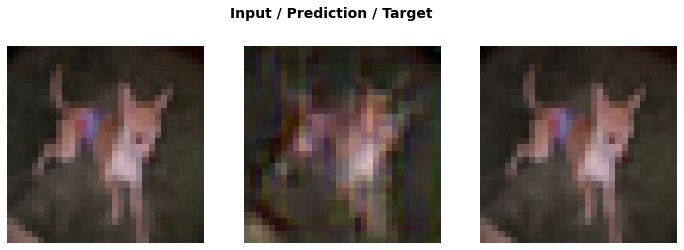

In [52]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [100,100,100])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [54]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,3.542583,5.075800,0.012394,0.080691,00:16
1,3.692981,5.524908,0.015510,0.092092,00:15
2,4.071268,5.963588,0.014703,0.089196,00:15
3,4.296169,5.977787,0.015446,0.091760,00:15
4,4.335386,5.940011,0.016077,0.094719,00:15
5,4.286382,5.696546,0.015297,0.090980,00:15
6,4.144349,5.586316,0.014045,0.086649,00:15
7,3.960616,5.386565,0.014710,0.088968,00:15
8,3.790259,5.327537,0.014480,0.088555,00:15
9,3.682356,5.297013,0.014464,0.088215,00:15


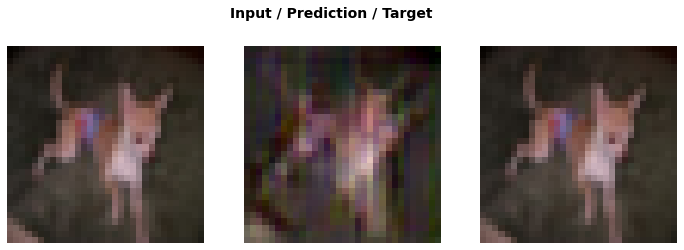

In [55]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [200,150,100])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [57]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,4.420781,6.446603,0.014140,0.087169,00:15
1,4.539538,6.689621,0.015162,0.091169,00:15
2,4.852618,7.125234,0.017661,0.099549,00:15
3,5.053510,7.016796,0.015072,0.090168,00:14
4,5.095123,7.048422,0.017140,0.098825,00:15
5,5.011776,6.804855,0.015079,0.090612,00:15
6,4.844601,6.633294,0.014521,0.088248,00:15
7,4.668060,6.405796,0.014281,0.087973,00:15
8,4.482701,6.309931,0.014179,0.087192,00:15
9,4.351063,6.291477,0.014320,0.087857,00:15


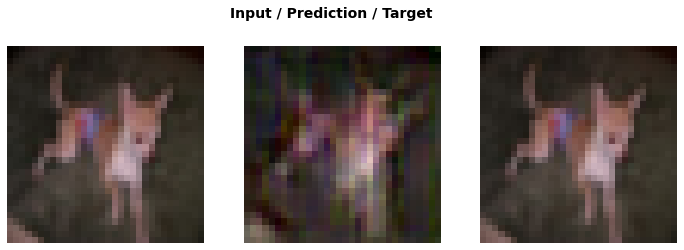

In [58]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [200,0,0])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [60]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.377700,1.723017,0.013189,0.083948,00:15
1,1.335421,1.725932,0.012685,0.082334,00:15
2,1.326669,1.700024,0.012138,0.080468,00:15
3,1.310726,1.648993,0.012045,0.079795,00:15
4,1.280503,1.615991,0.011790,0.078979,00:15
5,1.252135,1.575419,0.012254,0.080996,00:15
6,1.225052,1.571386,0.013121,0.085372,00:15
7,1.197031,1.528332,0.011084,0.075748,00:15
8,1.171269,1.513008,0.011232,0.076586,00:15
9,1.151976,1.508689,0.011206,0.076397,00:15


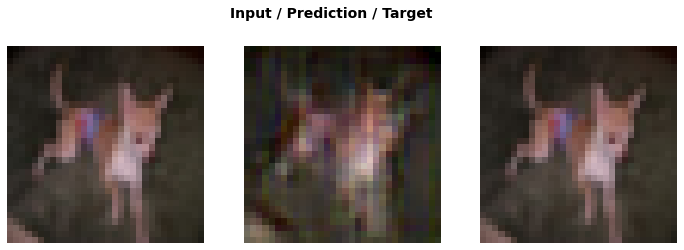

In [61]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [200,100,0])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [63]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.369919,1.834557,0.011486,0.077566,00:14
1,1.408942,2.201133,0.020048,0.110472,00:14
2,1.467567,1.935621,0.013245,0.085616,00:15
3,1.464368,1.910304,0.012834,0.083857,00:15
4,1.448609,1.892098,0.012171,0.080382,00:15
5,1.424173,1.846948,0.012352,0.081833,00:15
6,1.394783,1.819489,0.011315,0.076851,00:15
7,1.365478,1.795678,0.011948,0.080060,00:15
8,1.338233,1.774261,0.011425,0.077314,00:15
9,1.321314,1.771270,0.011346,0.077130,00:15


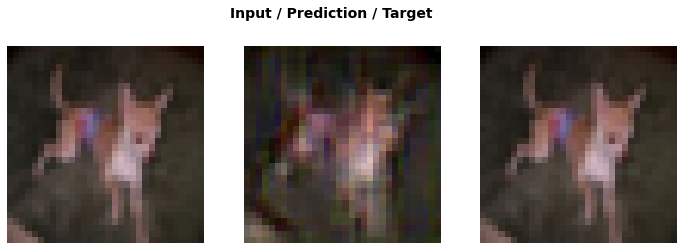

In [64]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [0,0,200])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [66]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,5.819615,8.980763,0.013220,0.084512,00:15
1,6.123449,9.678098,0.013605,0.085356,00:15
2,6.828564,10.413152,0.016391,0.094808,00:15
3,7.306499,10.630172,0.018696,0.104153,00:15
4,7.495400,10.397902,0.015134,0.090665,00:14
5,7.384983,10.006957,0.016918,0.097460,00:15
6,7.082423,9.726743,0.015563,0.092258,00:15
7,6.723356,9.566314,0.015350,0.091823,00:15
8,6.399879,9.362243,0.014566,0.089350,00:15
9,6.150178,9.305782,0.014560,0.089220,00:15


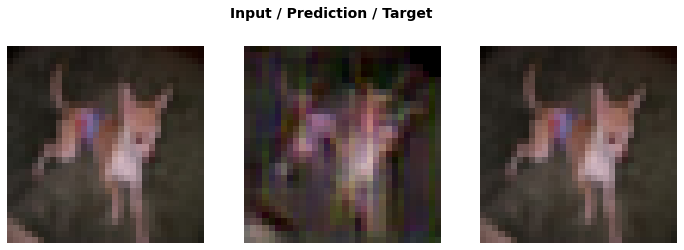

In [67]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [500,500,500])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [69]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,26.265480,40.077648,0.014115,0.087088,00:15
1,26.878855,41.847054,0.016864,0.096994,00:14
2,28.670298,43.786232,0.017313,0.098776,00:15
3,30.080954,44.431770,0.018762,0.103354,00:14
4,30.582525,44.121681,0.017221,0.098788,00:14
5,30.125635,42.460144,0.017750,0.100136,00:15
6,29.089636,41.594311,0.017013,0.098363,00:15
7,27.745398,40.543907,0.016387,0.095763,00:15
8,26.813822,40.024448,0.016739,0.097429,00:15
9,25.991482,39.796581,0.016160,0.095177,00:15


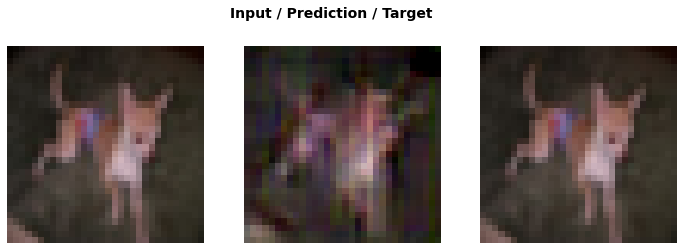

In [70]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[1:4], [200,0,0])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [72]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.835044,2.142144,0.016231,0.096554,00:15
1,1.690834,2.040163,0.012537,0.083658,00:14
2,1.590691,1.974043,0.011466,0.080193,00:14
3,1.534389,1.935142,0.011991,0.082969,00:14
4,1.472512,1.826506,0.010217,0.074871,00:14
5,1.423996,1.807487,0.010773,0.077181,00:14
6,1.383188,1.758133,0.009844,0.073343,00:14
7,1.352797,1.742622,0.009472,0.071450,00:14
8,1.331016,1.722267,0.009948,0.073918,00:14
9,1.318231,1.715791,0.009619,0.072303,00:15


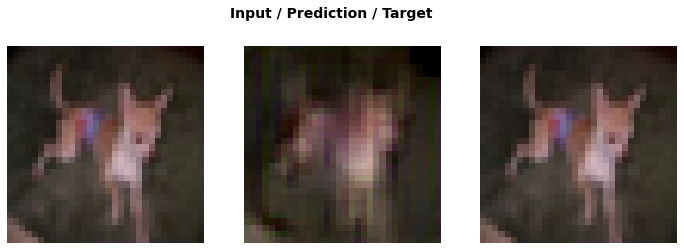

In [73]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [200,0,0])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [75]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.698431,1.059135,0.009841,0.075174,00:14
1,0.682651,1.345935,0.011624,0.081563,00:14
2,0.672495,1.046752,0.008906,0.069499,00:14
3,0.658052,1.012674,0.007791,0.064619,00:14
4,0.643902,1.007177,0.009666,0.073951,00:14
5,0.629545,0.971518,0.007021,0.060742,00:14
6,0.613107,0.950246,0.006808,0.059782,00:14
7,0.601725,0.924938,0.006859,0.059857,00:14
8,0.589412,0.915537,0.006811,0.059510,00:14
9,0.581298,0.912128,0.006790,0.059456,00:15


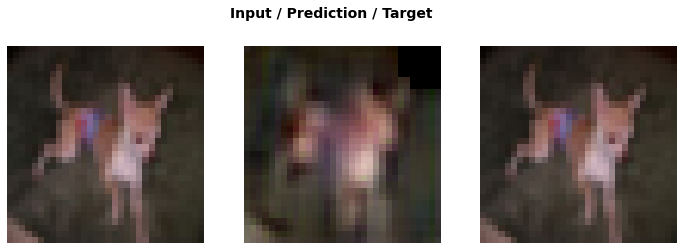

In [76]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [200,100,50])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [78]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,1.584433,2.232358,0.006737,0.059521,00:15
1,1.566542,2.455357,0.007989,0.066025,00:15
2,1.576036,2.296237,0.007521,0.063413,00:14
3,1.578933,2.244081,0.007568,0.063963,00:14
4,1.555699,2.246600,0.007228,0.061962,00:14
5,1.526289,2.240789,0.007168,0.062709,00:15
6,1.501127,2.122710,0.006976,0.060594,00:14
7,1.477893,2.158891,0.006444,0.057989,00:14
8,1.458517,2.069437,0.006303,0.056922,00:14
9,1.446978,2.059216,0.006364,0.057300,00:14


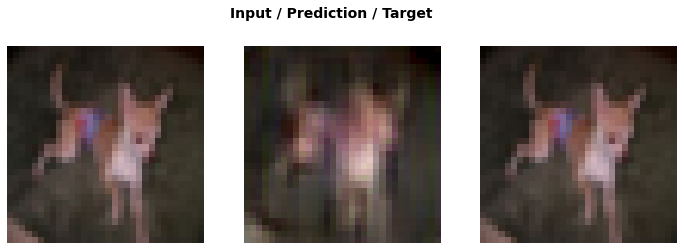

In [79]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [200,200,200])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [81]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,2.899157,4.068447,0.006997,0.060757,00:14
1,2.917769,4.182836,0.008005,0.066466,00:14
2,2.963388,4.165106,0.007783,0.065470,00:14
3,2.978312,4.284745,0.007430,0.063900,00:14
4,2.966998,4.369703,0.008091,0.066658,00:14
5,2.930756,4.154047,0.007867,0.065614,00:14
6,3.073684,4.233808,0.008805,0.070138,00:14
7,2.978052,4.000568,0.006967,0.060793,00:14
8,2.892608,3.933888,0.006711,0.059470,00:14
9,2.841249,3.930353,0.006769,0.059931,00:14


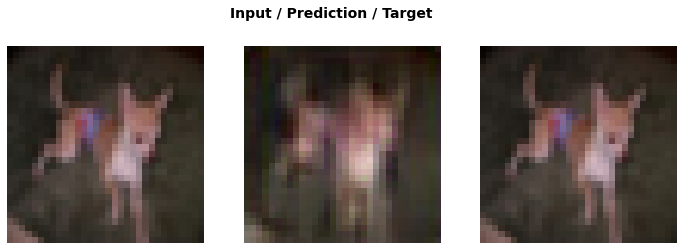

In [82]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [10,10,10])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [84]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.135122,0.186707,0.006184,0.056671,00:14
1,0.135010,0.193113,0.007004,0.061348,00:14
2,0.137135,0.195438,0.009027,0.072350,00:14
3,0.137595,0.196657,0.007381,0.063883,00:14
4,0.136908,0.190903,0.009017,0.074463,00:14
5,0.135208,0.184311,0.005976,0.055469,00:14
6,0.133439,0.183138,0.006253,0.057643,00:14
7,0.131701,0.182305,0.006066,0.056266,00:14
8,0.129886,0.178797,0.005738,0.054162,00:14
9,0.128371,0.178163,0.005718,0.053986,00:14


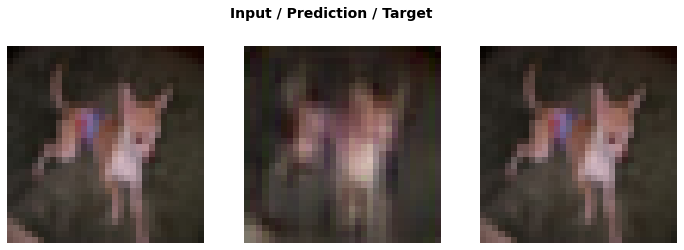

In [85]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [10,5,2])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [87]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.062810,0.089451,0.005591,0.053483,00:14
1,0.062811,0.094482,0.006697,0.061100,00:14
2,0.063561,0.094999,0.008078,0.068199,00:14
3,0.063886,0.095239,0.008776,0.072263,00:14
4,0.063425,0.090149,0.005768,0.055463,00:14
5,0.062608,0.089512,0.005812,0.055452,00:14
6,0.062135,0.096765,0.009038,0.072839,00:15
7,0.062056,0.087455,0.005267,0.051957,00:14
8,0.061004,0.086282,0.005055,0.050487,00:15
9,0.060348,0.086115,0.005031,0.050201,00:14


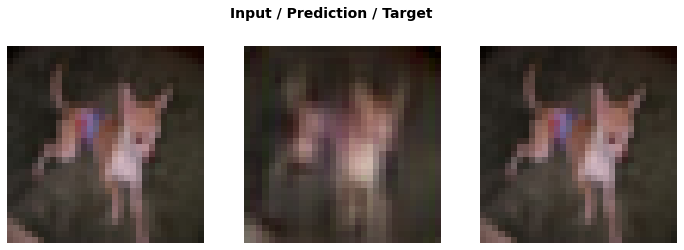

In [88]:
learn.show_results(rows = 1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [10,20,30])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [90]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.272218,0.383482,0.005609,0.053797,00:15
1,0.273346,0.392268,0.006653,0.060502,00:15
2,0.282019,0.426618,0.009669,0.074946,00:15
3,0.283558,0.394805,0.008619,0.072096,00:14
4,0.281158,0.385893,0.006088,0.056294,00:14
5,0.278403,0.381737,0.006095,0.057073,00:14
6,0.273597,0.374603,0.005837,0.054924,00:14
7,0.268454,0.369391,0.005657,0.053822,00:14
8,0.264109,0.366077,0.005588,0.053276,00:14
9,0.260748,0.365122,0.005674,0.053929,00:14


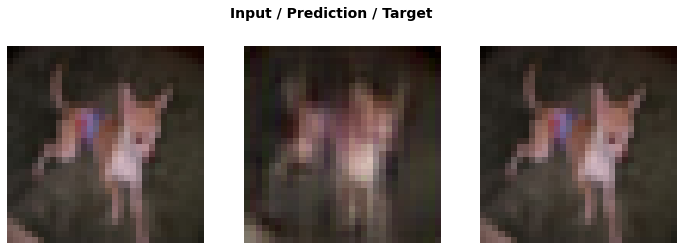

In [91]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [30,20,10])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [93]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.217383,0.313429,0.005507,0.053141,00:15
1,0.218145,0.322598,0.007000,0.063070,00:14
2,0.221497,0.335668,0.011161,0.082585,00:14
3,0.232739,0.322153,0.006020,0.056040,00:14
4,0.226925,0.316430,0.006082,0.057354,00:15
5,0.222153,0.310807,0.005428,0.052814,00:14
6,0.218269,0.308393,0.005471,0.053292,00:14
7,0.214959,0.306311,0.005226,0.051450,00:14
8,0.212245,0.303932,0.005227,0.051612,00:14
9,0.210510,0.303396,0.005244,0.051793,00:14


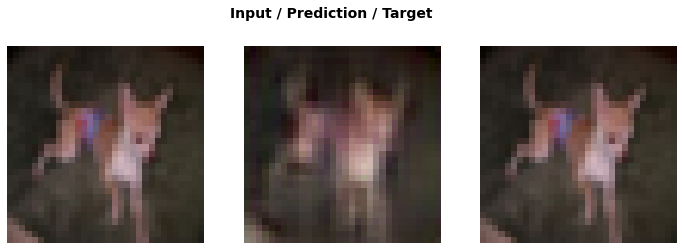

In [94]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [20,5,10])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [96]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.114983,0.169037,0.005239,0.051945,00:15
1,0.118140,0.242104,0.034801,0.164667,00:15
2,0.121317,0.174739,0.005484,0.053234,00:15
3,0.120840,0.174534,0.005414,0.053029,00:15
4,0.120208,0.173405,0.005530,0.053828,00:14
5,0.118683,0.170657,0.005384,0.053250,00:15
6,0.117418,0.168867,0.005081,0.050959,00:14
7,0.116115,0.167780,0.005207,0.051825,00:14
8,0.114398,0.166128,0.004978,0.050086,00:14
9,0.113219,0.165704,0.004944,0.049909,00:14


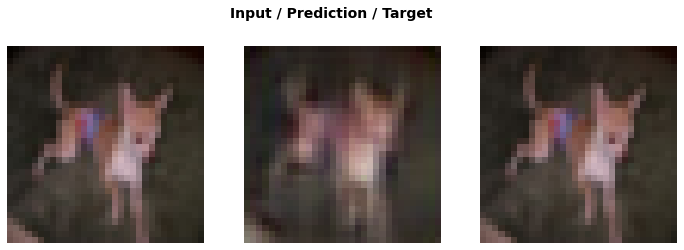

In [97]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [20,5,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [99]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.072434,0.109274,0.004869,0.049564,00:15
1,0.072648,0.111186,0.005182,0.051932,00:14
2,0.073466,0.116996,0.005977,0.057264,00:15
3,0.073735,0.111451,0.005180,0.052271,00:15
4,0.073615,0.113049,0.005544,0.054256,00:15
5,0.072894,0.109082,0.005048,0.051893,00:15
6,0.071976,0.108997,0.005756,0.056135,00:15
7,0.070925,0.105909,0.004525,0.047690,00:15
8,0.070322,0.105084,0.004432,0.046971,00:15
9,0.069781,0.104871,0.004424,0.046934,00:15


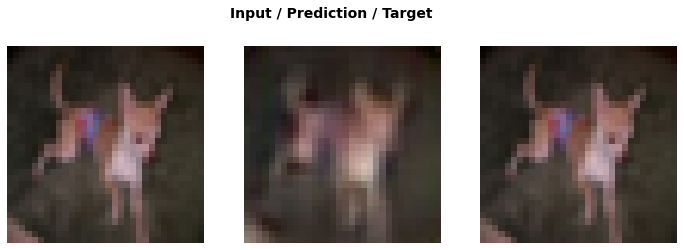

In [100]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [20,20,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [102]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.140740,0.208181,0.004876,0.050102,00:14
1,0.142054,0.211812,0.005472,0.054390,00:14
2,0.144231,0.212869,0.005556,0.054536,00:14
3,0.145108,0.214236,0.005333,0.053069,00:14
4,0.144472,0.208531,0.005144,0.051733,00:14
5,0.148226,0.253918,0.014734,0.094949,00:14
6,0.146907,0.206752,0.005589,0.054826,00:14
7,0.142969,0.202775,0.004827,0.049492,00:14
8,0.140059,0.201484,0.004784,0.049147,00:14
9,0.138464,0.201119,0.004781,0.049154,00:14


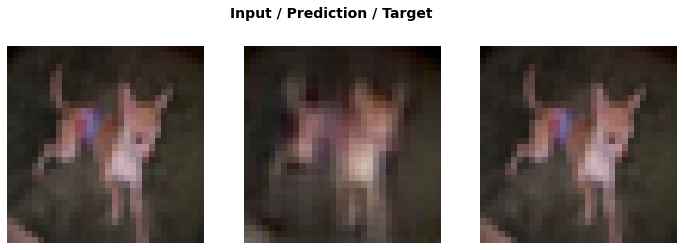

In [103]:
learn.show_results(rows=1)

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[0:3], [5,20,1])
learn = Learner(data, autoencoder, loss_func = feat_loss, metrics = [mean_squared_error, mean_absolute_error])

In [105]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.107542,0.154993,0.004961,0.050354,00:14
1,0.108651,0.159756,0.005899,0.056124,00:14
2,0.111066,0.163249,0.006863,0.061954,00:14
3,0.111629,0.159288,0.005425,0.053574,00:14
4,0.111896,0.157244,0.005189,0.052069,00:14
5,0.110506,0.155359,0.005303,0.052657,00:14
6,0.109102,0.154666,0.005745,0.055692,00:14
7,0.107536,0.152374,0.004967,0.050469,00:14
8,0.105976,0.150105,0.004780,0.048914,00:14
9,0.105185,0.149729,0.004733,0.048659,00:14


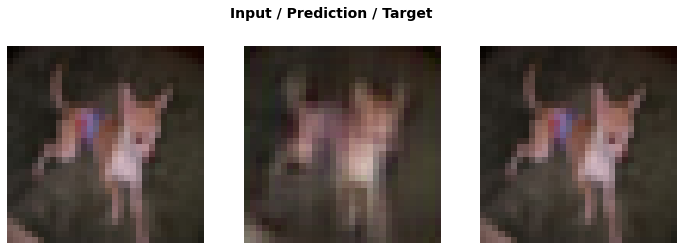

In [106]:
learn.show_results(rows=1)

In [0]:
learn.loss_func = F.mse_loss

In [109]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,time
0,0.003172,0.004579,0.004579,0.048139,00:11
1,0.003084,0.004746,0.004746,0.050040,00:11
2,0.002954,0.004407,0.004407,0.047665,00:11
3,0.002897,0.005190,0.005190,0.053267,00:11
4,0.002843,0.004443,0.004443,0.048184,00:12
5,0.002795,0.004139,0.004139,0.045803,00:11
6,0.002738,0.004020,0.004020,0.044694,00:11
7,0.002742,0.004191,0.004191,0.046268,00:11
8,0.002678,0.003898,0.003898,0.043789,00:11
9,0.002616,0.003875,0.003875,0.043568,00:11


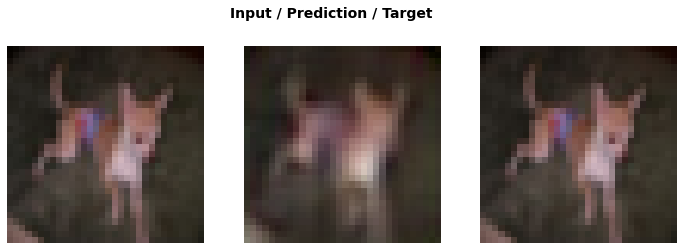

In [110]:
learn.show_results(rows=1)